# Location-Based Solar Energy Analysis

This notebook demonstrates how location affects solar energy production patterns and provides tools for analyzing solar systems across different geographic locations.

**Key Features:**
- 🌍 **Location-aware modeling** - Solar irradiance calculations based on latitude/longitude
- 🌤️ **Climate adjustments** - Weather patterns and seasonal variations by location
- ☀️ **Solar geometry** - Accurate sunrise/sunset times and solar elevation angles
- 📊 **Comparative analysis** - Compare solar potential across different locations
- 🎯 **Enhanced accuracy** - More realistic production estimates using location data

In [1]:
# Import libraries
import sys
sys.path.append('../src')

from core.location_manager import LocationManager
from core.data_manager import SolarDataManager
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

print("🌍 Location-Based Solar Energy Analysis")
print("=" * 50)

🌍 Location-Based Solar Energy Analysis


/Users/christopherhaught/projects/power-usage-and-consumption/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Create Location Manager

The system will automatically use your location from the `.env` file if configured, or you can specify it manually.

In [ ]:
from core.location_loader import create_notebook_location, load_location_from_env, get_location_electricity_rates

# Option 1: Automatic location from .env file (RECOMMENDED)
location = create_notebook_location()  # Uses .env settings or Denver fallback

# Check if location came from .env file
env_location = load_location_from_env('../.env')
if env_location:
    print(f"✅ Using location from .env file: {env_location.location_name}")
else:
    print(f"📍 No location in .env file, using fallback: {location.location_name}")
    print(f"💡 To configure your location, edit .env file:")
    print(f"   SOLAR_LOCATION_CITY=your_city")
    print(f"   OR set coordinates: SOLAR_LOCATION_LATITUDE=xx.xxxx, SOLAR_LOCATION_LONGITUDE=yy.yyyy")

# Option 2: Manual override (uncomment to use specific location)
# location = LocationManager.from_city('phoenix')  # Override with specific city
# location = LocationManager(37.7749, -122.4194, 'America/Los_Angeles', 'San Francisco, CA')

print(f"\n📍 Analysis Location: {location}")
print(f"\n📊 Location Summary:")
summary = location.get_location_summary()
for key, value in summary.items():
    if isinstance(value, float):
        print(f"   {key.replace('_', ' ').title()}: {value:.2f}")
    else:
        print(f"   {key.replace('_', ' ').title()}: {value}")

## 2. Generate Location-Specific Mock Data

Let's generate solar data specifically tailored to our location's solar characteristics.

In [3]:
# Check if location-specific mock data exists, if not generate it
city_name = location.location_name.split(',')[0].lower().replace(' ', '_').replace('.', '')
location_data_path = f"../data/raw/mock_solar_data_{city_name}.csv"

if not Path(location_data_path).exists():
    print(f"📥 Generating location-specific data for {location.location_name}...")
    
    # Import and run the generation function
    import sys
    sys.path.append('../scripts')
    from generate_mock_data import generate_mock_solar_data
    
    # Generate 6 months of data for better seasonal analysis
    mock_data = generate_mock_solar_data(
        start_date="2024-01-01", 
        num_days=180,  # 6 months
        location=location
    )
    
    # Save the data
    mock_data.to_csv(location_data_path, index=False)
    print(f"✅ Generated and saved location-specific data to: {location_data_path}")
else:
    print(f"✅ Using existing location-specific data: {location_data_path}")

# Initialize data manager with location-specific data
class MockEnphaseClient:
    def get_energy_lifetime(self, start_date=None, end_date=None):
        return pd.DataFrame()

data_manager = SolarDataManager(
    csv_path=location_data_path,
    enphase_client=MockEnphaseClient(),
    cache_dir="../data/processed"
)

print(f"📊 Data manager initialized with location-specific data")

📥 Generating location-specific data for Holly Springs, NC...
✅ Generated and saved location-specific data to: ../data/raw/mock_solar_data_holly_springs.csv
📊 Data manager initialized with location-specific data


## 3. Load and Enhance Solar Data with Location Information

In [4]:
# Load the CSV data
solar_data = data_manager.load_csv_data()
daily_data = data_manager.get_daily_production()

print(f"📈 Dataset Overview:")
print(f"   Records: {len(solar_data):,} (15-minute intervals)")
print(f"   Days: {len(daily_data)}")
print(f"   Date range: {solar_data.index.min().date()} to {solar_data.index.max().date()}")
print(f"   Location: {location.location_name}")

# Enhance data with location-specific information
print(f"\n🔧 Enhancing data with location-specific calculations...")
enhanced_data = location.enhance_solar_data(solar_data)

print(f"✅ Added location-based columns:")
new_columns = [col for col in enhanced_data.columns if col not in solar_data.columns]
for col in new_columns:
    print(f"   - {col}")

# Display sample of enhanced data
print(f"\n📋 Sample Enhanced Data:")
sample_cols = ['Production (kWh)', 'solar_elevation', 'theoretical_irradiance', 
               'seasonal_factor', 'weather_factor']
sample_data = enhanced_data[sample_cols].iloc[480:485]  # Midday sample
print(sample_data.round(3))

INFO:core.data_manager:Loading CSV data from ../data/raw/mock_solar_data_holly_springs.csv
INFO:core.data_manager:Loaded 17280 CSV records from 2024-01-01 00:00:00 to 2024-06-28 23:45:00
INFO:core.data_manager:Using mock client - skipping API data retrieval


📈 Dataset Overview:
   Records: 17,280 (15-minute intervals)
   Days: 180
   Date range: 2024-01-01 to 2024-06-28
   Location: Holly Springs, NC

🔧 Enhancing data with location-specific calculations...
✅ Added location-based columns:
   - solar_elevation
   - theoretical_irradiance
   - seasonal_factor
   - weather_factor
   - sunrise_hour
   - sunset_hour
   - daylight_hours

📋 Sample Enhanced Data:
                     Production (kWh)  solar_elevation  \
Date/Time                                                
2024-01-06 00:00:00               0.0              0.0   
2024-01-06 00:15:00               0.0              0.0   
2024-01-06 00:30:00               0.0              0.0   
2024-01-06 00:45:00               0.0              0.0   
2024-01-06 01:00:00               0.0              0.0   

                     theoretical_irradiance  seasonal_factor  weather_factor  
Date/Time                                                                     
2024-01-06 00:00:00            

## 4. Analyze Location-Specific Solar Patterns

In [5]:
# Calculate daily solar metrics
daily_enhanced = enhanced_data.resample('D').agg({
    'Production (kWh)': 'sum',
    'Consumption (kWh)': 'sum',
    'solar_elevation': 'max',
    'theoretical_irradiance': 'max',
    'seasonal_factor': 'mean',
    'weather_factor': 'mean',
    'daylight_hours': 'first'
})

# Add derived metrics
daily_enhanced['production_per_daylight_hour'] = daily_enhanced['Production (kWh)'] / daily_enhanced['daylight_hours']
daily_enhanced['month'] = daily_enhanced.index.month
daily_enhanced['day_of_year'] = daily_enhanced.index.dayofyear

# Monthly analysis
monthly_stats = daily_enhanced.groupby('month').agg({
    'Production (kWh)': ['mean', 'std', 'min', 'max'],
    'daylight_hours': 'mean',
    'theoretical_irradiance': 'mean',
    'seasonal_factor': 'mean',
    'weather_factor': 'mean'
}).round(2)

print(f"📊 Monthly Solar Statistics for {location.location_name}:")
print(monthly_stats)

📊 Monthly Solar Statistics for Holly Springs, NC:
      Production (kWh)                     daylight_hours  \
                  mean   std    min    max           mean   
month                                                       
1                 3.00  0.57   2.09   4.04           9.88   
2                 6.34  1.57   4.19   9.17          10.71   
3                14.32  3.29   9.86  20.13          11.81   
4                26.60  3.95  19.29  34.78          12.96   
5                39.22  4.02  32.05  48.90          13.92   
6                46.18  2.47  39.89  50.77          14.38   

      theoretical_irradiance seasonal_factor weather_factor  
                        mean            mean           mean  
month                                                        
1                     371.82            0.56           0.33  
2                     496.72            0.72           0.36  
3                     658.57            0.96           0.42  
4                     794.88

## 5. Visualize Location-Specific Solar Patterns

/var/folders/c4/7rqcnh_x3_s594r5nysgtb280000gn/T/ipykernel_99243/3869676153.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot(monthly_prod, labels=month_labels)


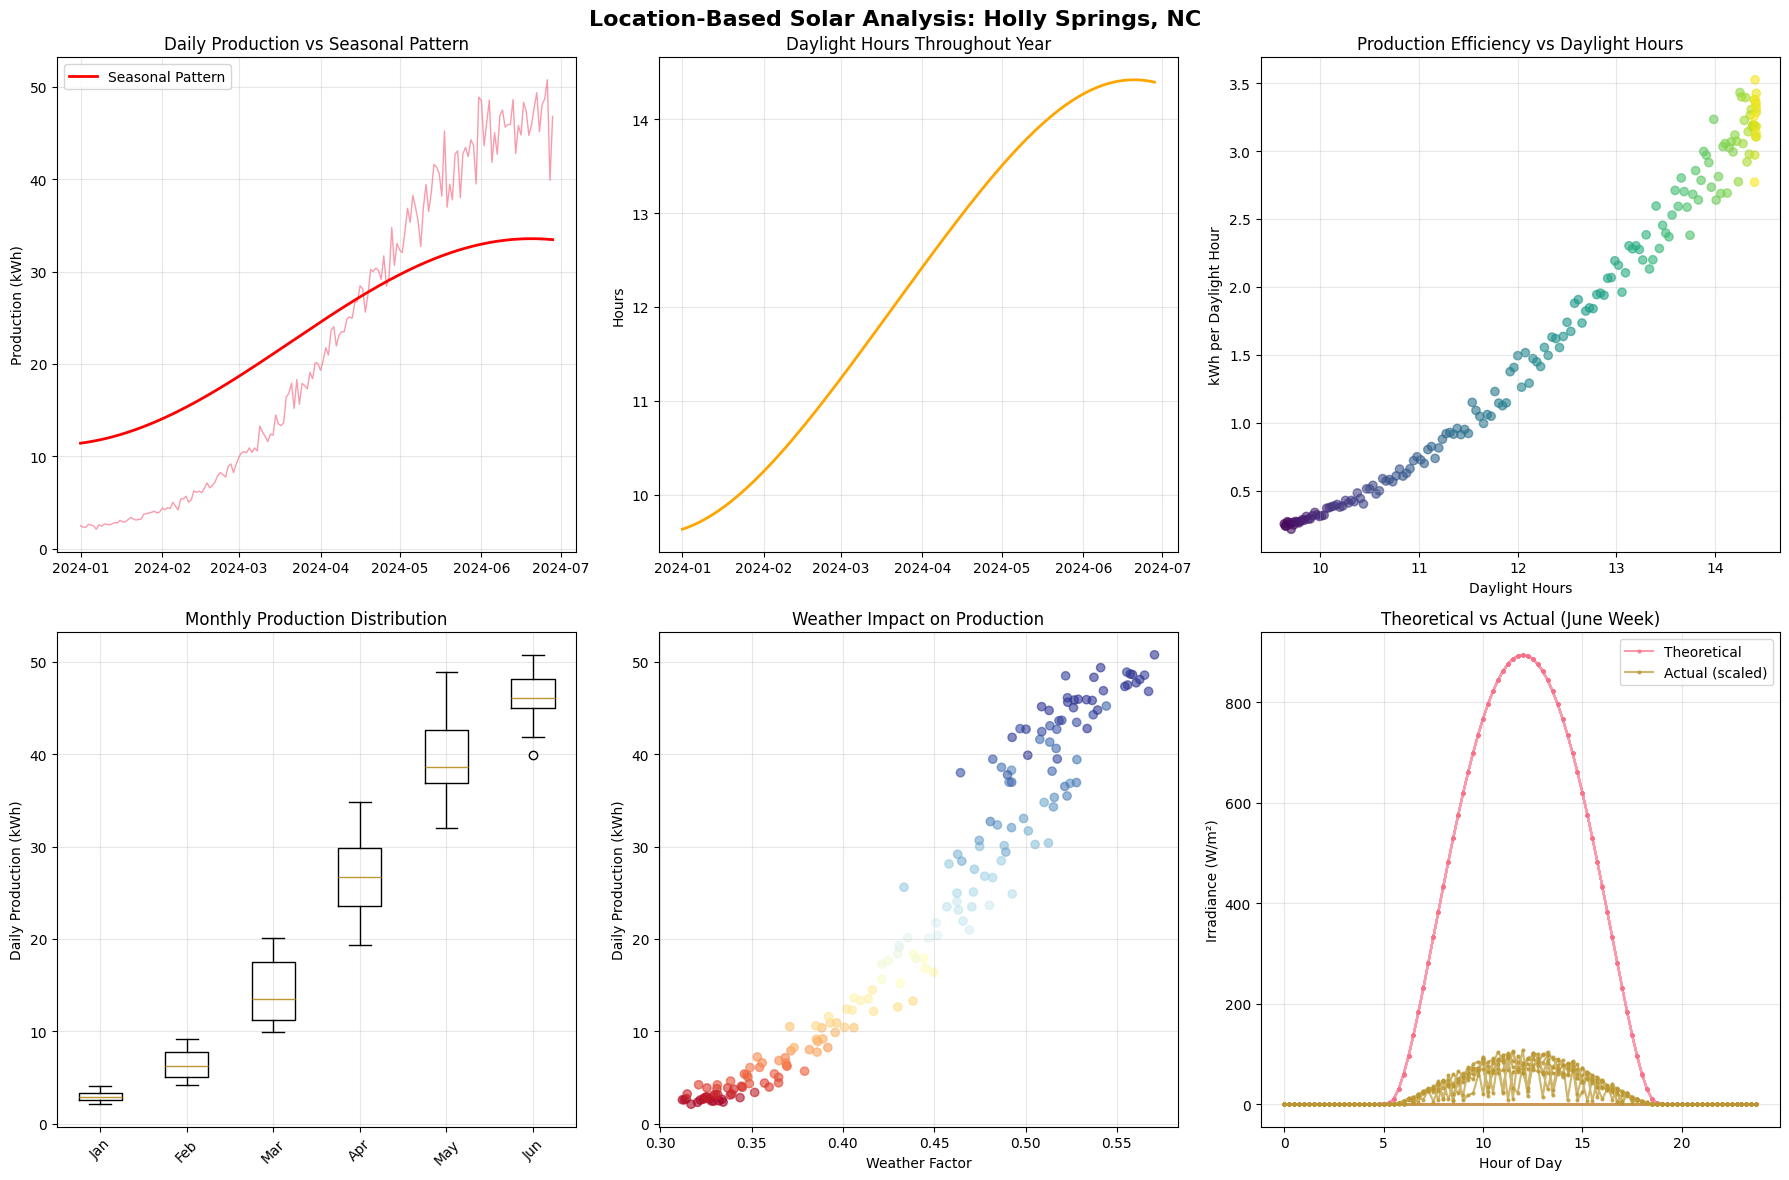

In [6]:
# Create comprehensive location-based solar analysis plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Location-Based Solar Analysis: {location.location_name}', fontsize=16, fontweight='bold')

# 1. Daily production over time with seasonal overlay
axes[0,0].plot(daily_enhanced.index, daily_enhanced['Production (kWh)'], alpha=0.7, linewidth=1)
axes[0,0].plot(daily_enhanced.index, daily_enhanced['seasonal_factor'] * daily_enhanced['Production (kWh)'].mean(), 
              color='red', linewidth=2, label='Seasonal Pattern')
axes[0,0].set_title('Daily Production vs Seasonal Pattern')
axes[0,0].set_ylabel('Production (kWh)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Daylight hours throughout the year
axes[0,1].plot(daily_enhanced.index, daily_enhanced['daylight_hours'], color='orange', linewidth=2)
axes[0,1].set_title('Daylight Hours Throughout Year')
axes[0,1].set_ylabel('Hours')
axes[0,1].grid(True, alpha=0.3)

# 3. Production efficiency (kWh per daylight hour)
axes[0,2].scatter(daily_enhanced['daylight_hours'], daily_enhanced['production_per_daylight_hour'], 
                 c=daily_enhanced['day_of_year'], cmap='viridis', alpha=0.6)
axes[0,2].set_title('Production Efficiency vs Daylight Hours')
axes[0,2].set_xlabel('Daylight Hours')
axes[0,2].set_ylabel('kWh per Daylight Hour')
axes[0,2].grid(True, alpha=0.3)

# 4. Monthly production distribution
monthly_prod = [daily_enhanced[daily_enhanced['month'] == m]['Production (kWh)'].values 
               for m in range(1, 13) if m in daily_enhanced['month'].values]
month_labels = [datetime(2024, m, 1).strftime('%b') 
               for m in range(1, 13) if m in daily_enhanced['month'].values]
axes[1,0].boxplot(monthly_prod, labels=month_labels)
axes[1,0].set_title('Monthly Production Distribution')
axes[1,0].set_ylabel('Daily Production (kWh)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 5. Weather factor impact
axes[1,1].scatter(daily_enhanced['weather_factor'], daily_enhanced['Production (kWh)'], 
                 alpha=0.6, c=daily_enhanced['seasonal_factor'], cmap='RdYlBu')
axes[1,1].set_title('Weather Impact on Production')
axes[1,1].set_xlabel('Weather Factor')
axes[1,1].set_ylabel('Daily Production (kWh)')
axes[1,1].grid(True, alpha=0.3)

# 6. Theoretical vs actual irradiance
sample_week = enhanced_data['2024-06-15':'2024-06-21']  # Mid-summer week
axes[1,2].plot(sample_week.index.hour + sample_week.index.minute/60, 
              sample_week['theoretical_irradiance'], 'o-', markersize=2, 
              label='Theoretical', alpha=0.7)
axes[1,2].plot(sample_week.index.hour + sample_week.index.minute/60, 
              sample_week['Production (kWh)'] * 50, 'o-', markersize=2, 
              label='Actual (scaled)', alpha=0.7)
axes[1,2].set_title('Theoretical vs Actual (June Week)')
axes[1,2].set_xlabel('Hour of Day')
axes[1,2].set_ylabel('Irradiance (W/m²)')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Compare with Other Locations

Let's compare our location with other cities to understand relative solar potential.

In [7]:
# Compare with other major cities
comparison_cities = ['phoenix', 'miami', 'seattle', 'denver']
location_comparison = {}

print(f"🌍 Comparing solar potential across locations:")
print(f"\n{'Location':<20} {'Climate':<15} {'Summer DL':<10} {'Winter DL':<10} {'Season Var':<12} {'Cloud Factor':<12}")
print("-" * 85)

for city in comparison_cities:
    try:
        loc = LocationManager.from_city(city)
        summary = loc.get_location_summary()
        location_comparison[city] = summary
        
        print(f"{summary['location_name']:<20} {summary['climate_type']:<15} {summary['summer_daylight_hours']:<10.1f} "
              f"{summary['winter_daylight_hours']:<10.1f} {summary['seasonal_variation']:<12.2f} "
              f"{summary['typical_cloud_factor']:<12.2f}")
              
    except Exception as e:
        print(f"Could not load {city}: {e}")

# Add current location
current_summary = location.get_location_summary()
print(f"\n>>> {current_summary['location_name']:<16} {current_summary['climate_type']:<15} "
      f"{current_summary['summer_daylight_hours']:<10.1f} {current_summary['winter_daylight_hours']:<10.1f} "
      f"{current_summary['seasonal_variation']:<12.2f} {current_summary['typical_cloud_factor']:<12.2f} <<<")

INFO:core.location_manager:LocationManager initialized for Phoenix, AZ
INFO:core.location_manager:LocationManager initialized for Miami, FL
INFO:core.location_manager:LocationManager initialized for Seattle, WA
INFO:core.location_manager:LocationManager initialized for Denver, CO


🌍 Comparing solar potential across locations:

Location             Climate         Summer DL  Winter DL  Season Var   Cloud Factor
-------------------------------------------------------------------------------------
Phoenix, AZ          Subtropical     14.2       9.8        0.30         0.80        
Miami, FL            Subtropical     13.6       10.4       0.30         0.80        
Seattle, WA          Temperate       15.8       8.2        0.50         0.75        
Denver, CO           Temperate       14.8       9.2        0.50         0.75        

>>> Holly Springs, NC Temperate       14.4       9.6        0.50         0.75         <<<


## 7. Solar Geometry Analysis

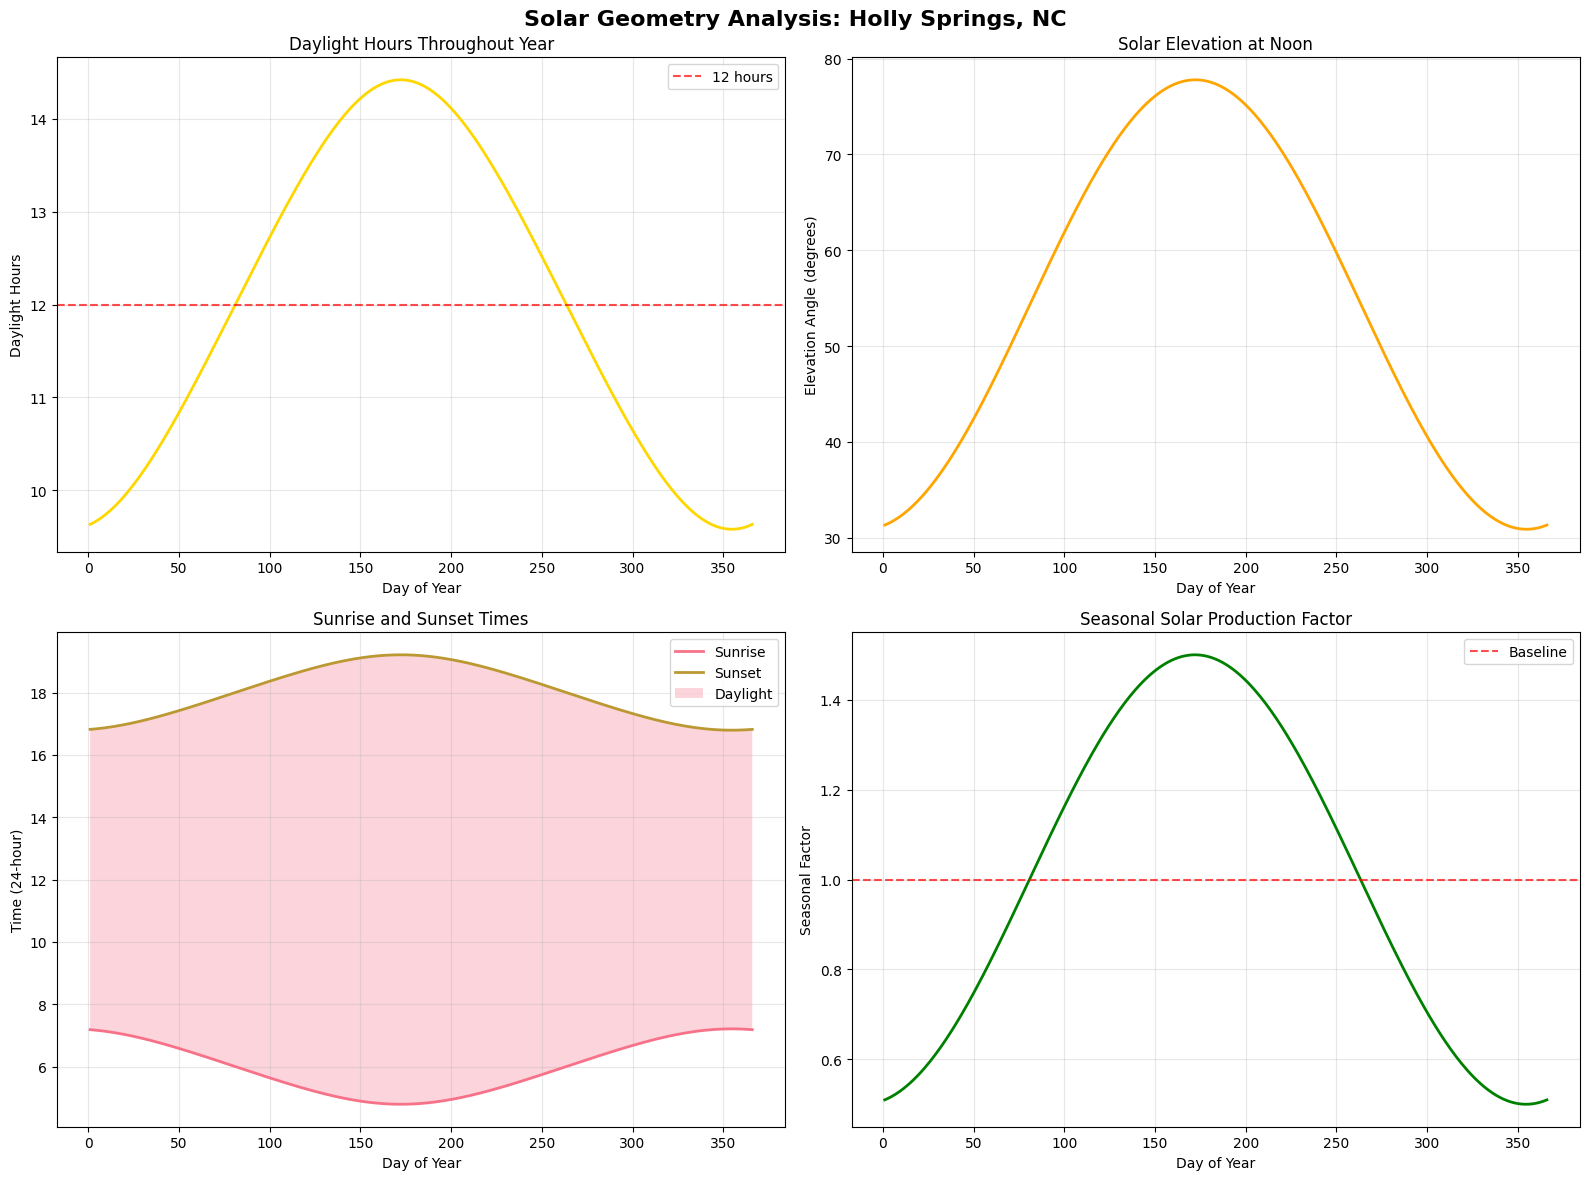


☀️ Key Solar Geometry Facts for Holly Springs, NC:
   Longest day: 14.4 hours 
   Shortest day: 9.6 hours
   Daylight variation: 4.8 hours
   Max solar elevation: 77.8°
   Min solar elevation: 30.9°
   Seasonal factor range: 0.50 to 1.50


In [8]:
# Analyze solar geometry throughout the year
dates_analysis = pd.date_range('2024-01-01', '2024-12-31', freq='D')
solar_geometry = []

for date in dates_analysis:
    sunrise, sunset = location.get_sunrise_sunset(date)
    noon_elevation = location.get_solar_elevation(date.replace(hour=12))
    seasonal_factor = location.get_seasonal_adjustment_factor(date)
    
    solar_geometry.append({
        'date': date,
        'sunrise': sunrise,
        'sunset': sunset,
        'daylight_hours': sunset - sunrise,
        'noon_elevation': noon_elevation,
        'seasonal_factor': seasonal_factor,
        'day_of_year': date.timetuple().tm_yday
    })

geometry_df = pd.DataFrame(solar_geometry)

# Plot solar geometry analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Solar Geometry Analysis: {location.location_name}', fontsize=16, fontweight='bold')

# 1. Daylight hours throughout year
axes[0,0].plot(geometry_df['day_of_year'], geometry_df['daylight_hours'], linewidth=2, color='gold')
axes[0,0].set_title('Daylight Hours Throughout Year')
axes[0,0].set_xlabel('Day of Year')
axes[0,0].set_ylabel('Daylight Hours')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=12, color='red', linestyle='--', alpha=0.7, label='12 hours')
axes[0,0].legend()

# 2. Solar elevation at noon
axes[0,1].plot(geometry_df['day_of_year'], geometry_df['noon_elevation'], linewidth=2, color='orange')
axes[0,1].set_title('Solar Elevation at Noon')
axes[0,1].set_xlabel('Day of Year')
axes[0,1].set_ylabel('Elevation Angle (degrees)')
axes[0,1].grid(True, alpha=0.3)

# 3. Sunrise and sunset times
axes[1,0].plot(geometry_df['day_of_year'], geometry_df['sunrise'], label='Sunrise', linewidth=2)
axes[1,0].plot(geometry_df['day_of_year'], geometry_df['sunset'], label='Sunset', linewidth=2)
axes[1,0].fill_between(geometry_df['day_of_year'], geometry_df['sunrise'], geometry_df['sunset'], 
                      alpha=0.3, label='Daylight')
axes[1,0].set_title('Sunrise and Sunset Times')
axes[1,0].set_xlabel('Day of Year')
axes[1,0].set_ylabel('Time (24-hour)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Seasonal adjustment factor
axes[1,1].plot(geometry_df['day_of_year'], geometry_df['seasonal_factor'], linewidth=2, color='green')
axes[1,1].set_title('Seasonal Solar Production Factor')
axes[1,1].set_xlabel('Day of Year')
axes[1,1].set_ylabel('Seasonal Factor')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Baseline')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Print key solar geometry facts
print(f"\n☀️ Key Solar Geometry Facts for {location.location_name}:")
print(f"   Longest day: {geometry_df.loc[geometry_df['daylight_hours'].idxmax(), 'daylight_hours']:.1f} hours ")
print(f"   Shortest day: {geometry_df.loc[geometry_df['daylight_hours'].idxmin(), 'daylight_hours']:.1f} hours")
print(f"   Daylight variation: {geometry_df['daylight_hours'].max() - geometry_df['daylight_hours'].min():.1f} hours")
print(f"   Max solar elevation: {geometry_df['noon_elevation'].max():.1f}°")
print(f"   Min solar elevation: {geometry_df['noon_elevation'].min():.1f}°")
print(f"   Seasonal factor range: {geometry_df['seasonal_factor'].min():.2f} to {geometry_df['seasonal_factor'].max():.2f}")

## 8. Location Impact on Financial Analysis

In [ ]:
# Location-specific financial analysis using actual electricity rates
# Get location-specific electricity rates
nrel_api_key = None  # Load from .env if available
try:
    import os
    from pathlib import Path
    env_path = Path('../.env')
    if env_path.exists():
        with open(env_path) as f:
            for line in f:
                if line.strip().startswith('NREL_API_KEY=') and not line.strip().startswith('#'):
                    nrel_api_key = line.split('=', 1)[1].strip()
                    break
except Exception:
    pass

electricity_rates = get_location_electricity_rates(location, nrel_api_key)
ELECTRICITY_RATE = electricity_rates['annual_cost_per_kwh']  # $/kWh from location data
FEED_IN_RATE = electricity_rates['feed_in_rate_per_kwh']  # $/kWh for excess energy
SYSTEM_COST_PER_KW = 2500  # $/kW installed
SYSTEM_SIZE_KW = 10  # 10kW system

# Calculate location-specific metrics
total_days = len(daily_enhanced)
annual_production = daily_enhanced['Production (kWh)'].sum() * (365 / total_days)
annual_savings = annual_production * ELECTRICITY_RATE
system_cost = SYSTEM_SIZE_KW * SYSTEM_COST_PER_KW
payback_period = system_cost / annual_savings

# Capacity factor (actual production / theoretical maximum)
capacity_factor = annual_production / (SYSTEM_SIZE_KW * 8760) * 100

# Compare with other climates (theoretical)
climate_multipliers = {
    'Desert (Phoenix)': 1.4,
    'Sunny Subtropical (Miami)': 1.2,
    'Temperate (Denver)': 1.0,
    'Cloudy Maritime (Seattle)': 0.7
}

print(f"💰 Location-Specific Financial Analysis: {location.location_name}")
print(f"=" * 60)
print(f"\n🏠 System Specifications:")
print(f"   System size: {SYSTEM_SIZE_KW} kW")
print(f"   Installation cost: ${system_cost:,}")
print(f"   Electricity rate: ${ELECTRICITY_RATE:.3f}/kWh ({electricity_rates['source']})")
print(f"   Feed-in rate: ${FEED_IN_RATE:.3f}/kWh")
print(f"   Rate comparison: {electricity_rates['national_comparison']['vs_national_avg']:+.1f}¢ vs national avg")

print(f"\n📊 Location Performance:")
print(f"   Climate type: {current_summary['climate_type']}")
print(f"   Annual production estimate: {annual_production:,.0f} kWh")
print(f"   Capacity factor: {capacity_factor:.1f}%")
print(f"   Daily average: {annual_production/365:.1f} kWh/day")
print(f"   Peak day: {daily_enhanced['Production (kWh)'].max():.1f} kWh")
print(f"   Low day: {daily_enhanced['Production (kWh)'].min():.1f} kWh")

print(f"\n💵 Financial Metrics:")
print(f"   Annual electricity savings: ${annual_savings:,.0f}")
print(f"   Simple payback period: {payback_period:.1f} years")
print(f"   25-year savings: ${annual_savings * 25 - system_cost:,.0f}")
print(f"   ROI (25 years): {((annual_savings * 25 - system_cost) / system_cost) * 100:.0f}%")

print(f"\n🌍 Climate Comparison (Theoretical):")
for climate, multiplier in climate_multipliers.items():
    adjusted_production = annual_production * multiplier
    adjusted_savings = adjusted_production * ELECTRICITY_RATE
    adjusted_payback = system_cost / adjusted_savings
    print(f"   {climate:<25}: {adjusted_production:>6,.0f} kWh/yr, "
          f"${adjusted_savings:>5,.0f}/yr, {adjusted_payback:>4.1f} yr payback")

# Create financial comparison visualization
climates = list(climate_multipliers.keys())
productions = [annual_production * mult for mult in climate_multipliers.values()]
paybacks = [system_cost / (prod * ELECTRICITY_RATE) for prod in productions]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Annual production by climate
bars1 = ax1.bar(climates, productions, alpha=0.7)
ax1.axhline(y=annual_production, color='red', linestyle='--', 
           label=f'{location.location_name}: {annual_production:,.0f} kWh')
ax1.set_title('Annual Production by Climate')
ax1.set_ylabel('Annual Production (kWh)')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Payback period by climate
bars2 = ax2.bar(climates, paybacks, alpha=0.7, color='orange')
ax2.axhline(y=payback_period, color='red', linestyle='--', 
           label=f'{location.location_name}: {payback_period:.1f} years')
ax2.set_title('Payback Period by Climate')
ax2.set_ylabel('Payback Period (years)')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary and Recommendations

In [10]:
# Generate location-specific recommendations
climate_type = current_summary['climate_type']
seasonal_var = current_summary['seasonal_variation']
daylight_var = current_summary['summer_daylight_hours'] - current_summary['winter_daylight_hours']

print(f"🎯 LOCATION-BASED SOLAR ANALYSIS SUMMARY")
print(f"=" * 50)
print(f"\n📍 Location: {location.location_name}")
print(f"   Coordinates: {location.latitude:.3f}°, {location.longitude:.3f}°")
print(f"   Climate: {climate_type}")
print(f"   Timezone: {location.timezone_str or 'Not specified'}")

print(f"\n☀️ Solar Characteristics:")
print(f"   Capacity factor: {capacity_factor:.1f}% (US average: ~20-25%)")
print(f"   Seasonal variation: {seasonal_var:.1f} (0=none, 1=extreme)")
print(f"   Daylight variation: {daylight_var:.1f} hours (summer-winter)")
print(f"   Cloud factor: {current_summary['typical_cloud_factor']:.2f} (1=clear, 0=always cloudy)")

print(f"\n💡 System Performance:")
print(f"   Expected annual production: {annual_production:,.0f} kWh")
print(f"   Production per kW installed: {annual_production/SYSTEM_SIZE_KW:,.0f} kWh/kW/year")
print(f"   Best month average: {daily_enhanced.groupby('month')['Production (kWh)'].mean().max():.1f} kWh/day")
print(f"   Worst month average: {daily_enhanced.groupby('month')['Production (kWh)'].mean().min():.1f} kWh/day")

print(f"\n💰 Financial Outlook:")
print(f"   Payback period: {payback_period:.1f} years")
print(f"   Annual savings: ${annual_savings:,.0f}")
print(f"   25-year ROI: {((annual_savings * 25 - system_cost) / system_cost) * 100:.0f}%")

print(f"\n🎯 Recommendations:")

# Climate-specific recommendations
if climate_type == "Desert" or "Phoenix" in location.location_name:
    print(f"   ✅ Excellent solar resource! Very high production potential.")
    print(f"   💡 Consider dust cleaning systems for optimal performance.")
    print(f"   🌡️ Use high-temperature rated panels for hot climates.")
elif climate_type == "Tropical":
    print(f"   ⚠️ Good year-round sun but expect cloud/rain impacts.")
    print(f"   💡 Size system for rainy season performance.")
    print(f"   🌧️ Ensure good drainage and corrosion resistance.")
elif "Seattle" in location.location_name or current_summary['typical_cloud_factor'] < 0.75:
    print(f"   ☁️ Moderate solar resource due to frequent clouds.")
    print(f"   💡 Consider larger system to compensate for lower production.")
    print(f"   🔋 Battery storage may be valuable for cloudy periods.")
else:
    print(f"   ✅ Good solar resource for this climate zone.")
    print(f"   💡 Standard system sizing should work well.")

# Seasonal recommendations
if seasonal_var > 0.6:
    print(f"   ❄️ High seasonal variation - winter production much lower.")
    print(f"   💡 Consider battery storage or grid-tie for winter months.")
elif seasonal_var < 0.2:
    print(f"   🌴 Low seasonal variation - consistent year-round production.")

# Capacity factor recommendations
if capacity_factor > 25:
    print(f"   🎉 Excellent capacity factor! Above national average.")
elif capacity_factor < 15:
    print(f"   ⚠️ Lower capacity factor - ensure economics still work.")

print(f"\n✅ Location-based analysis complete!")
print(f"\nNext steps:")
print(f"- Use this location data for accurate system sizing")
print(f"- Apply location-specific factors to production forecasts")
print(f"- Consider climate-appropriate hardware selections")
print(f"- Generate location-specific mock data: python scripts/generate_mock_data.py {location.latitude} {location.longitude}")

🎯 LOCATION-BASED SOLAR ANALYSIS SUMMARY

📍 Location: Holly Springs, NC
   Coordinates: 35.668°, -78.850°
   Climate: Temperate
   Timezone: America/New York

☀️ Solar Characteristics:
   Capacity factor: 9.3% (US average: ~20-25%)
   Seasonal variation: 0.5 (0=none, 1=extreme)
   Daylight variation: 4.8 hours (summer-winter)
   Cloud factor: 0.75 (1=clear, 0=always cloudy)

💡 System Performance:
   Expected annual production: 8,167 kWh
   Production per kW installed: 817 kWh/kW/year
   Best month average: 46.2 kWh/day
   Worst month average: 3.0 kWh/day

💰 Financial Outlook:
   Payback period: 25.5 years
   Annual savings: $980
   25-year ROI: -2%

🎯 Recommendations:
   ✅ Good solar resource for this climate zone.
   💡 Standard system sizing should work well.
   ⚠️ Lower capacity factor - ensure economics still work.

✅ Location-based analysis complete!

Next steps:
- Use this location data for accurate system sizing
- Apply location-specific factors to production forecasts
- Consider 